In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import netCDF4 as nc
import statsmodels
import statsmodels.tsa.stattools as sts 
import statsmodels.graphics.tsaplots as sgt  
from scipy import fft as fourier
from scipy import stats
import matplotlib.pyplot as plt
import math

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import warnings
warnings.simplefilter('ignore')

In [3]:
path = f'{workspace}tesis/datos/'
altura_rio_file = 'procesados/datosAlturaDeRio_sorted_true.nc'

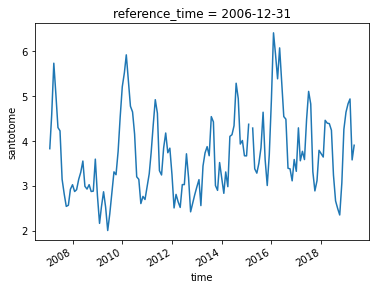

In [4]:
ds_altura = xr.open_dataset(path+altura_rio_file, engine='netcdf4')
ds_altura_santotome = ds_altura.santotome
ds_altura_santotome_mensual = ds_altura_santotome.resample(time='M', closed='right').mean()
ds_altura_santotome_mensual.plot()

In [49]:
df = pd.DataFrame(ds_altura_santotome_mensual, index=ds_altura_santotome_mensual.time, columns=['altura_rio'])
df.dropna(inplace=True)



In [51]:
def transformada_fourier(df):
    """create a fft and return
    the transform, amplitude and freq of a pd.series

    Args:
        df (pd.Series): pandas series with the time series to analyze

    Returns:
        return three numpy.arrays with transform, amplitudes and frequencies in respectively positions
    """
    transformada = fourier.fft(df)
    amp = abs(transformada)
    freq = fourier.fftfreq(len(df))

    return transformada, amp, freq

amp = transformada_fourier(df)[1]
freq = transformada_fourier(df)[2]


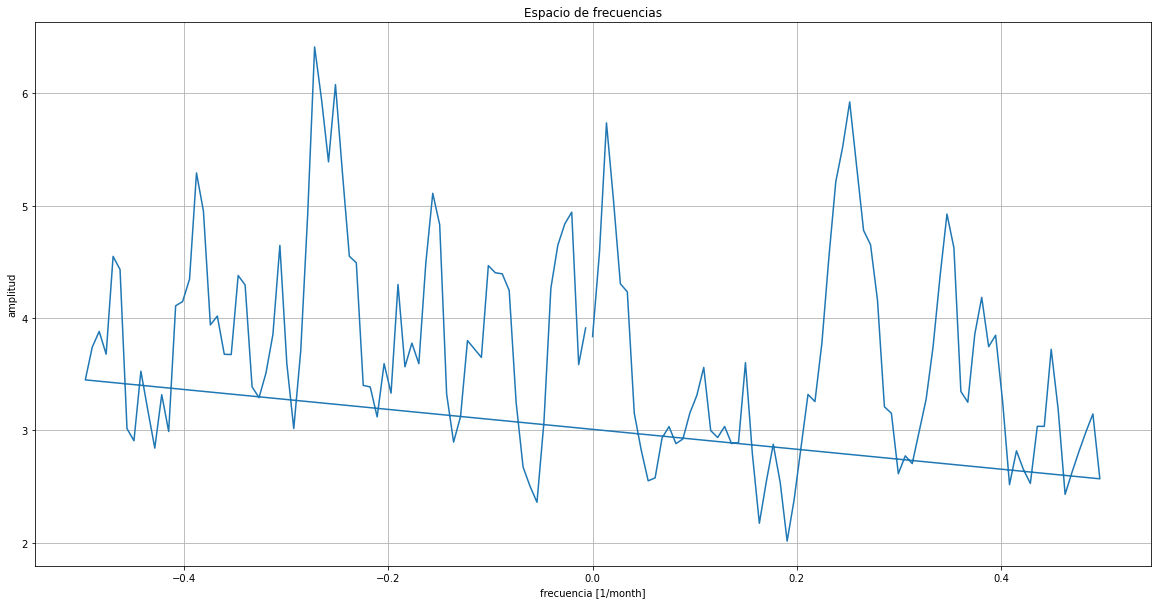

In [52]:
plt.figure(figsize=(20,10))
plt.plot(transformada_fourier(df)[2], transformada_fourier(df)[1])
plt.xlabel('frecuencia [1/month]')
plt.ylabel('amplitud')
plt.title('Espacio de frecuencias')
plt.grid()

In [53]:
info = pd.concat([pd.DataFrame(freq),pd.DataFrame(amp)], axis=1)
info.columns = ['freq', 'amp']
info_1 = info[info['freq']>=0].copy()
info_1[info_1['amp'] == info_1['amp'].max()]['freq']

37    0.251701
Name: freq, dtype: float64

In [54]:
import pymannkendall as mk

"""
And all Mann-Kendall tests return a named tuple which contained:

trend: tells the trend (increasing, decreasing or no trend)
h: True (if trend is present) or False (if the trend is absence)
p: p-value of the significance test
z: normalized test statistics
Tau: Kendall Tau
s: Mann-Kendal's score
var_s: Variance S
slope: Theil-Sen estimator/slope
intercept: intercept of Kendall-Theil Robust Line, for seasonal test, full period cycle consider as unit time step
sen's slope function required data vector. seasonal sen's slope also has optional input period, which by the default value is 12. Both sen's slope function return only slope value.
"""

#Hago un test de Mann kendall para ver si tiene una parte determinística.

def test_mk(df, alpha_mk):
    """_summary_

    Args:
        df (pandas.Series): time series to testing with mann-kendall test with
        alpha_mk (float): alpha level for testing
    """
    resultado_mk = mk.original_test(df, alpha=alpha_mk)
    resultado_mk

    if resultado_mk[1] == True:
        print(f'se concluye que se rechaza la hipotesis nula, en favor de la alternativa con una significancia del 5%: Tendencia = {resultado_mk[1]} con alpha de {alpha_mk}')
    else:
        print(f'no se puede rechazar la hipotesis nula en favor de la alternativa con una significancia del 5%')

test_mk(df, 0.05)

se concluye que se rechaza la hipotesis nula, en favor de la alternativa con una significancia del 5%: Tendencia = True con alpha de 0.05


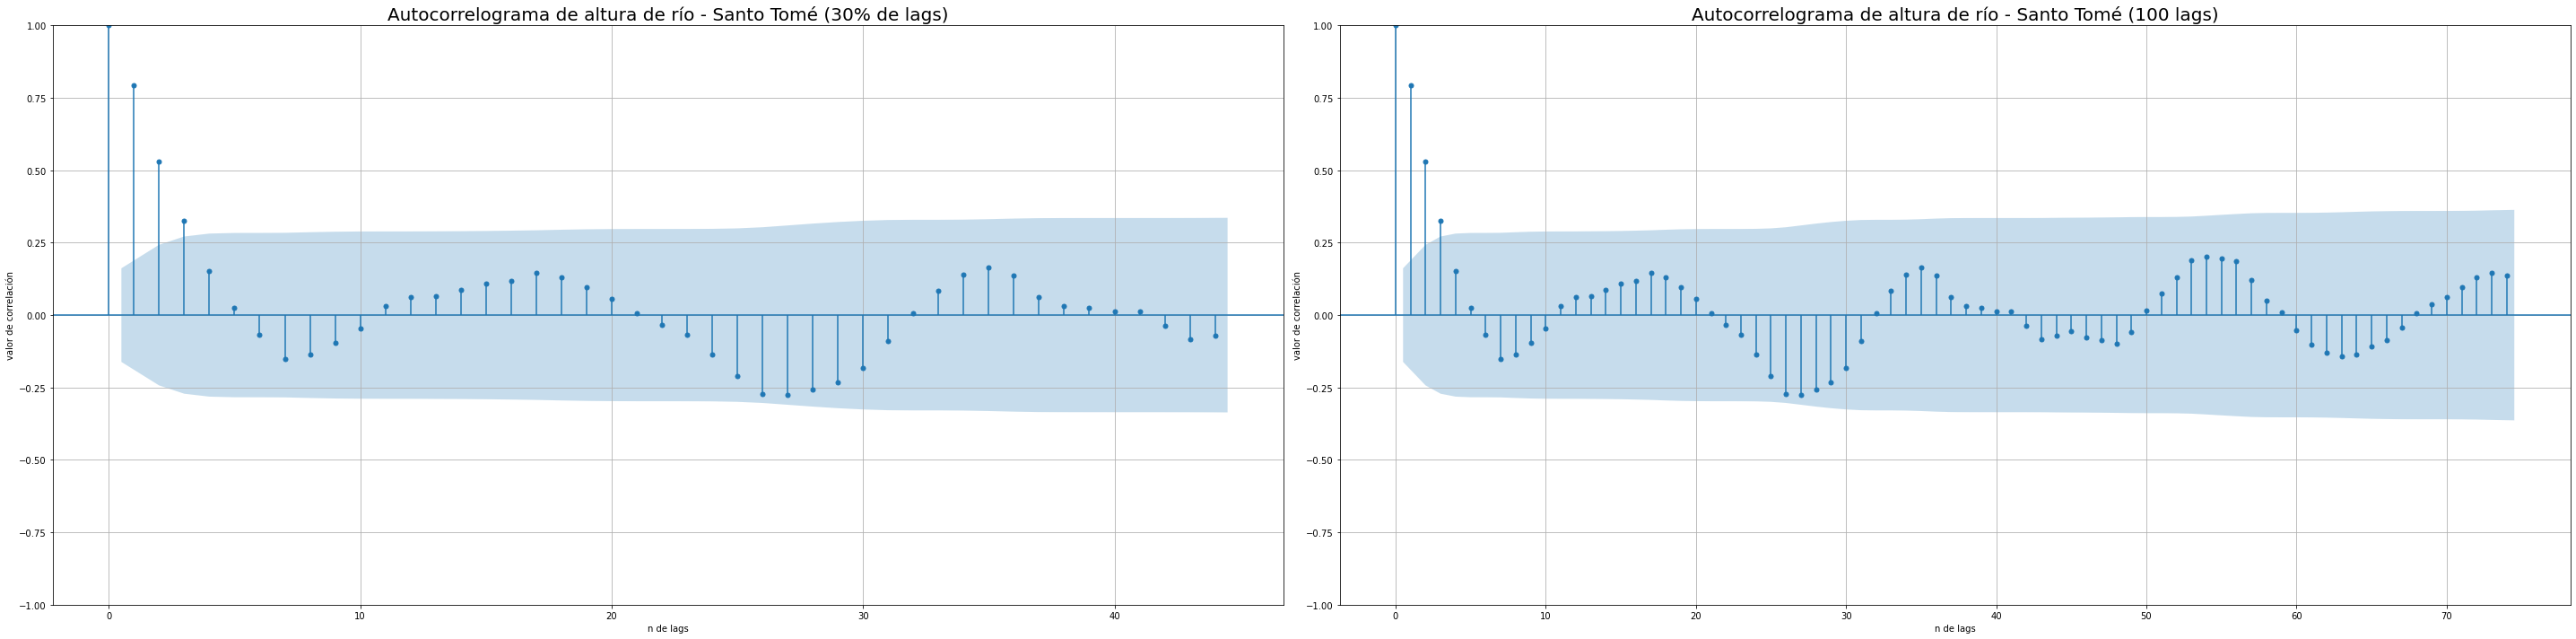

In [55]:
ax1 = plt.subplot(1,2,1)
sgt.plot_acf(df, lags = len(df)*0.3, ax=ax1)
plt.title('Autocorrelograma de altura de río - Santo Tomé (30% de lags)', size=20)
plt.xlabel('n de lags')
plt.ylabel('valor de correlación')
plt.grid()
ax2=plt.subplot(1,2,2)
sgt.plot_acf(df, lags = 148/2, ax=ax2).set_size_inches(40,10)
plt.title('Autocorrelograma de altura de río - Santo Tomé (100 lags)', size=20)
plt.xlabel('n de lags')
plt.ylabel('valor de correlación')
plt.grid()
plt.tight_layout()
plt.show()

In [56]:
rl = stats.linregress(y=df.altura_rio, x=np.arange(len(df.index)), alternative='two-sided')


In [57]:
def regresion_curve(df):
    rl = stats.linregress(y=df.altura_rio, x=np.arange(len(df.index)), alternative='two-sided')
    x = np.arange(len(df.index))
    y = rl[0]*x + rl[1] 
    line = {'x': x, 'y': y}
    
    return pd.DataFrame(line, index=df.index)

regresion_curve(df)


,x,y
2007-01-31,0,3.337167
2007-02-28,1,3.342010
2007-03-31,2,3.346853
2007-04-30,3,3.351696
2007-05-31,4,3.356538
...,...,...
2018-12-31,142,4.024837
2019-01-31,143,4.029680
2019-02-28,144,4.034522
2019-03-31,145,4.039365


In [58]:
regresion = regresion_curve(df)
regresion = regresion.drop(columns=['x'])
rl = stats.linregress(y=df.altura_rio, x=np.arange(len(df.index)), alternative='two-sided')
a=rl[0]
b=rl[1]


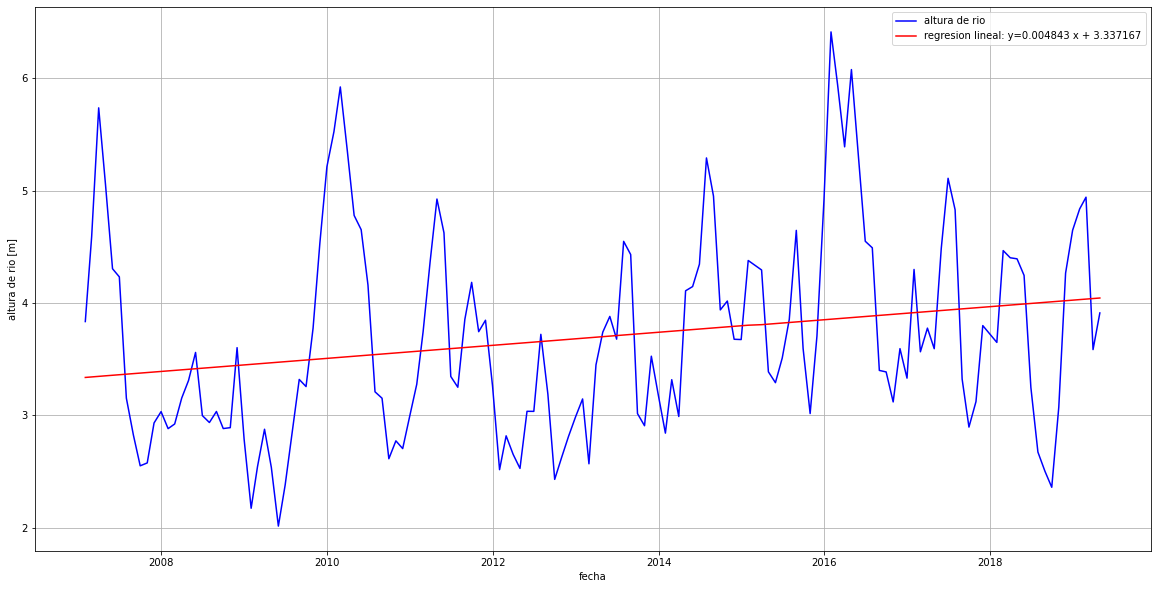

In [59]:
plt.figure(figsize=(20,10))
plt.plot(df, c='b', label='altura de rio')
plt.plot(regresion, c='r', label=f'regresion lineal: y={a:.6f} x + {b:.6f}')
plt.xlabel('fecha')
plt.ylabel('altura de rio [m]')
plt.grid()
plt.legend()

In [60]:
santotome_mensual_sin_tendencia = df.altura_rio - regresion.y


In [61]:
# Prueba

ft = np.fft.rfft(santotome_mensual_sin_tendencia[:-1]*np.hanning(len(santotome_mensual_sin_tendencia[:-1])), len(santotome_mensual_sin_tendencia[:-1]/2))
mgft = abs(ft)
xVals = np.fft.fftfreq(len(santotome_mensual_sin_tendencia[:-1]), d=1.0) # in days, or d=1.0/24 in days
freq_abs = pd.DataFrame({'freq': xVals[:len(mgft)],
             'abs':mgft})

freq_abs['var'] = (((freq_abs['abs']**2)/2)/(santotome_mensual_sin_tendencia.var()))*100


freq_abs

,freq,abs,var
0,0.000000,1.802729,209.651831
1,0.006849,8.929607,5144.020192
2,0.013699,18.215802,21405.952053
3,0.020548,13.464381,11695.284049
4,0.027397,6.851371,3028.258155
...,...,...,...
69,0.472603,1.903374,233.714788
70,0.479452,1.574924,160.013651
71,0.486301,1.788307,206.310982
72,0.493151,1.078671,75.061351


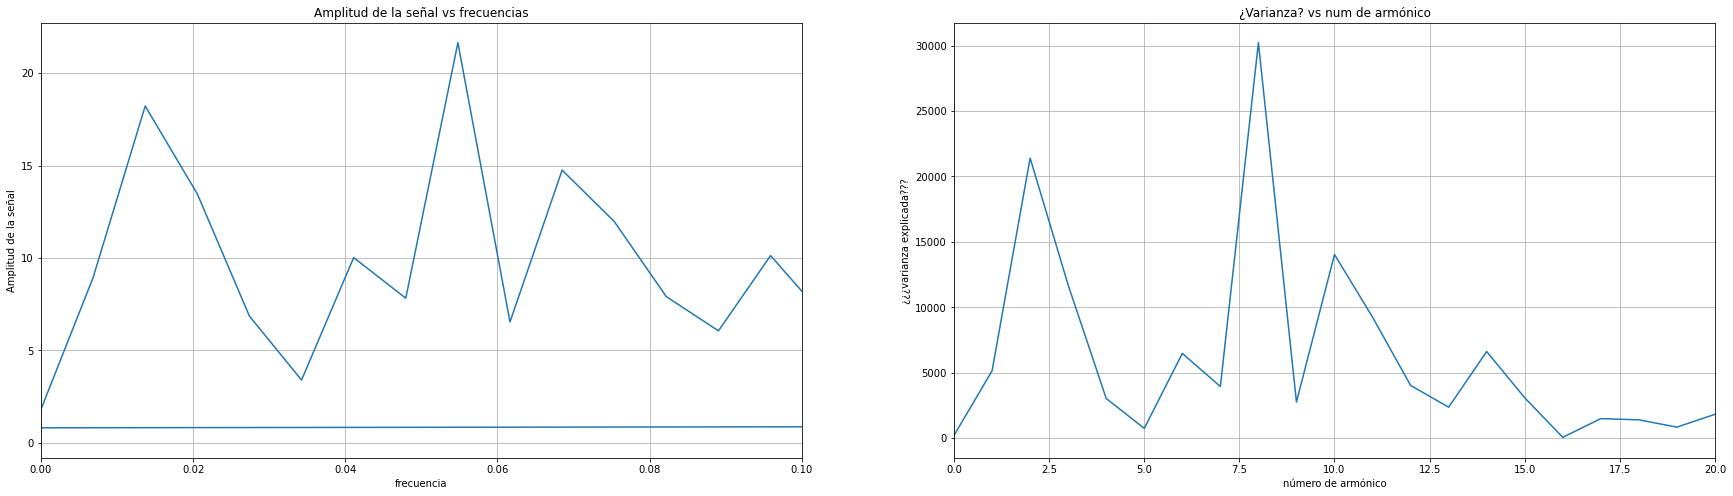

In [62]:
plt.figure(figsize=(30,8))
plt.subplot(1,2,1)
plt.plot(xVals[:len(mgft)], mgft)
plt.xlim(0,0.1)
plt.title('Amplitud de la señal vs frecuencias')
plt.xlabel('frecuencia')
plt.ylabel('Amplitud de la señal')
plt.grid()
plt.subplot(1,2,2)
plt.plot(freq_abs['var'])
plt.title('¿Varianza? vs num de armónico')
plt.xlabel('número de armónico')
plt.ylabel('¿¿¿varianza explicada???')
plt.xlim(0,20)
plt.grid()

In [63]:
freq_abs[freq_abs['abs'] == freq_abs['abs'].max()]

,freq,abs,var
8,0.054795,21.646072,30227.079404


In [64]:
len(santotome_mensual_sin_tendencia[:-1])/8

18.25

In [65]:
valor = santotome_mensual_sin_tendencia[:-1]
N  =  len(valor)
K = N/2
P = N	

########CAMBIAR EL N?MERO DE ARMONICO
M = 8 #ESTE VALOR HAY QUE CAMBIAR (el armónico que quiero filtrar)

###       Calcula el promedio

PROM = valor.mean()  

PI = 3.1415926

########### comienza!
##busco los coef A y B del armónico a filtrar

SUM = 0
SAM = 0

for J in np.arange(N): 
    SUM = SUM+valor[J]*np.sin(M*2*PI*(J+1)/P)
    SAM = SAM+valor[J]*np.cos(M*2*PI*(J+1)/P)

A = 2*SUM/N
B = 2*SAM/N

XS = np.zeros(N)
FIL = np.zeros(N)


for J in np.arange(N): 
    XS[J] = A*np.sin(2*PI*M*J/P)+B*np.cos(2*PI*M*J/P)


for I in np.arange(N): 
    FIL[I]= valor[I]-XS[I]

    
resultado = pd.DataFrame({'original':valor,
             'armonico':XS,
             'filtrado':FIL})

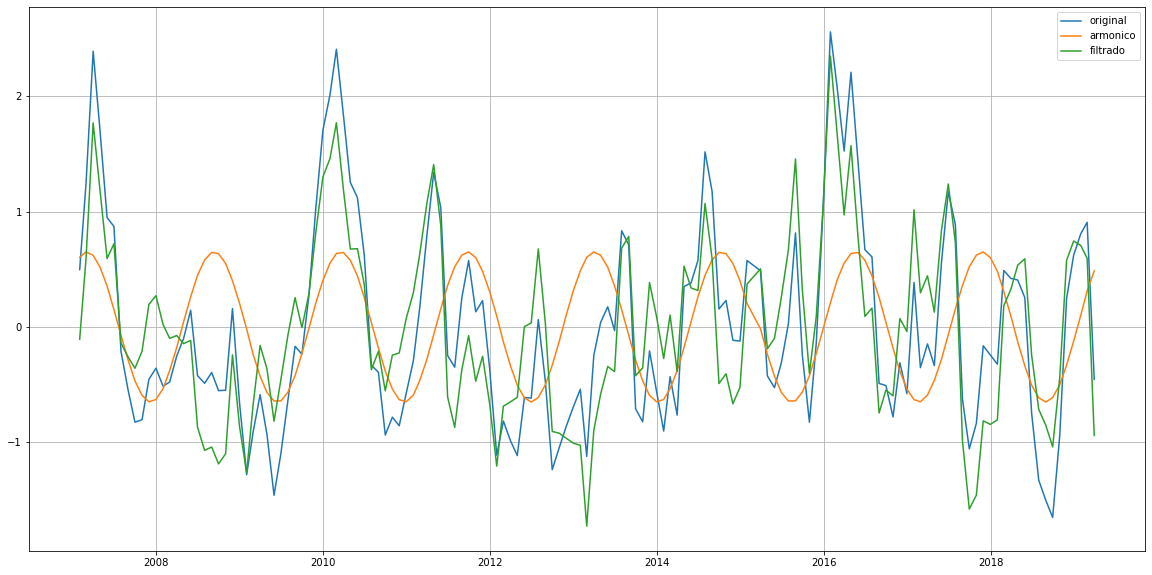

In [66]:
plt.figure(figsize=(20,10))
plt.plot(resultado)
plt.legend(['original','armonico','filtrado'])
plt.grid()

In [67]:
resultado

,original,armonico,filtrado
2007-01-31,0.497476,0.603852,-0.106376
2007-02-28,1.247990,0.650497,0.597493
2007-03-31,2.389814,0.620796,1.769018
2007-04-30,1.702971,0.518236,1.184736
2007-05-31,0.948128,0.354852,0.593276
...,...,...,...
2018-11-30,0.246006,-0.331044,0.577050
2018-12-31,0.622582,-0.122428,0.745010
2019-01-31,0.807417,0.100557,0.706860
2019-02-28,0.907016,0.311740,0.595276


In [68]:
altura_de_rio_sin_tendencia_ni_octavo_armonico = resultado[['filtrado']]
altura_de_rio_sin_tendencia_ni_octavo_armonico.to_csv(path+'alturaderiomensualsintendencianioctavoarmonico.csv')

In [69]:
df_altura = resultado[['filtrado']]
df_altura.columns = ['altura']
da_altura = xr.DataArray(df_altura['altura'], coords=[df_altura.index],dims=['time'])
ds_altura = xr.Dataset({'santotome': da_altura},
                      coords={'time': (df_altura.index)},
                      )
ds_altura


<xarray.Dataset>
Dimensions:    (time: 146)
Coordinates:
  * time       (time) datetime64[ns] 2007-01-31 2007-02-28 ... 2019-03-31
Data variables:
    santotome  (time) float64 -0.1064 0.5975 1.769 ... 0.7069 0.5953 -0.9407

In [70]:
ds_altura.to_netcdf(path=path+'alturaderiomensualsintendencianioctavoarmonico.nc', mode='w')